In [1]:
!pip install torch torchvision matplotlib scikit-learn

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


     ---------------------------------------- 15.6/15.6 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.


In [2]:
IMAGE_DIR = "../data/images"
MASK_DIR = "../data/masks"
MODEL_SAVE_PATH = "../model/unet_insat.pt"


In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.filenames = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.filenames[idx])
        
        image = Image.open(img_path).convert("L").resize((256,256))
        mask = Image.open(mask_path).convert("L").resize((256,256))

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0

        return torch.tensor(image).unsqueeze(0).float(), torch.tensor(mask).unsqueeze(0).float()


In [4]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_c, out_c): return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc1 = CBR(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = CBR(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))


In [5]:
dataset = SatelliteDataset(IMAGE_DIR, MASK_DIR)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, mask in dataloader:
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = loss_fn(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("✅ Model saved.")


Epoch 1/10, Loss: 11.5637
Epoch 2/10, Loss: 10.6028
Epoch 3/10, Loss: 6.5872
Epoch 4/10, Loss: 4.0003
Epoch 5/10, Loss: 3.2789
Epoch 6/10, Loss: 2.9269
Epoch 7/10, Loss: 2.7717
Epoch 8/10, Loss: 2.7277
Epoch 9/10, Loss: 2.5838
Epoch 10/10, Loss: 2.4645
✅ Model saved.


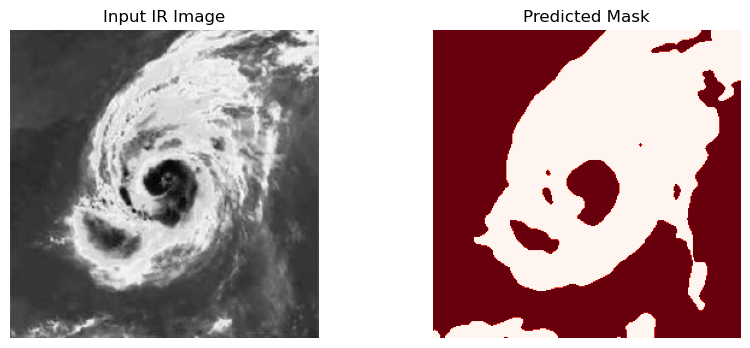

In [7]:
model.eval()
with torch.no_grad():
    for img, mask in dataloader:
        img = img.to(device)
        pred = model(img)
        break

# Select just the first image in the batch
input_image = img[0][0].cpu().numpy()
pred_mask = pred[0][0].cpu().numpy()

# Binarize the prediction
pred_binary = (pred_mask > 0.5).astype(np.uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap="gray")
plt.title("Input IR Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_binary, cmap="Reds")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()
